In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt # data visualization
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Scopo del notebook
Lo scopo di questo progetto è quello di iniziare ad ottenere familiarità con i concetti e gli strumenti relativi al Machine Learning a alla sua applicazione pratica. 
Nello specifico, l'obiettivo sarà quello di addestrare un modello di classificazione in grado di determinare se un preciso passeggero è sopravvissuto o meno all'affondo del titanic, sulla base dei dati a disposizione nel dataset e riguardanti età, ricchezza e stato sociale.

Tale modello verrà addestrato sui dati contenuti nel training set train.csv e successivamente testato su un testset apposito, sprovvisto delle label riguardanti la sopravvivenza dei passeggeri.

Se necessario e rilevante, nel corso del notebook, verranno effettuati anche dei tentativi di feature engineering, al fine di creare nuove feature in grado di descrivere i dati.


In [2]:
# importo i dataset dall'input del notebook
trainData = pd.read_csv("../input/titanic/train.csv");
testData = pd.read_csv("../input/titanic/test.csv");

In [3]:
# svolgo una prima analisi del dataset tramite le funzioni di pandas che mi danno informazioni sulla sua composizione
# consideriamo ora solamente il dataset di training
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
# ottengo alcune informazioni statistiche sul dataset
trainData.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# ottengo informazioni relative ad ogni colonna del dataset per quanto riguarda il tipo di dato 
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Possiamo subito notare come il dataset sia abbastanza completo in termini di dati, infatti abbiamo dei missing values solamente per quanto riguarda l'età di alcuni passeggeri e per quanto riguarda il numero di cabina. Questo ultimo fatto potrebbe essere più preoccupante in quanto non potremo sapere direttamente in che punto della nave erano collocati i passeggeri per i quali non è fornito il valore del numero di cabina.

Dal valore medio dell'attributo Survived, che vale 1 se il passeggero è sopravvissuto e 0 se è deceduto, posso subito constatare che la maggior parte dei passeggeri della nave non è riuscito a salvarsi.

Continuiamo ora con delle operazioni di preprocessing.

# PRE- PROCESSING

## Missing Values
E' molto importante rilevare ed occuparsi dei missing values all'interno del dataset, infatti la loro presenza potrebbe dare fastidio al training degli algoritmi di machine learning o potrebbe falsare i risultati ottenuti. 
Esistono perciò delle tecniche in grado di eliminarli oppure di trovare per essi un valore coerente.

Iniziamo con l'analisi dei missing values per quanto riguarda l'attributo "IMBARCATO", in quanto abbiamo solamente 2 missing values e siamo quindi di fronte ad una situazione più semplice.

In [6]:
# accedo solamente ai dati che hanno un valore nullo per l'attributo in questione
trainData.loc[pd.isnull(trainData["Embarked"])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Possiamo vedere come le due istanze che hanno un valore nullo nell'attributo che riguarda l'imbarco hanno lo stesso valore sia per quanto riguarda il prezzo sia per quanto riguarda la cabina assegnata. Le due passeggere, entrambe donne, però sono diverse in quanto hanno riportato un nome diverso. 
Ragionando,non possiamo concludere niente riguardo al posto in cui esse si sono imbarcate, perciò decidiamo di **lasciare un valore nullo**.

Continuiamo ora con i missing values riguardati l'età.

In [7]:
trainData.loc[pd.isnull(trainData["Age"])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


Anche per quanto riguarda l'età non possiamo dedurre niente dagli altri dati a nostra disposizione. Forse potremmo provare a dare un valore medio sulla base del valore medio degli altri passeggeri con una classe, una tariffa e un titolo simile. Sarebbe comunque una stima troppo approssimativa, in quanto sarebbe praticamente impossibile trovare il giusto valore nel continuo. Quindi passiamo oltre e analizziamo i dati mancanti per quanto riguarda la cabina.

In [8]:
noCabin = trainData.loc[pd.isnull(trainData["Cabin"])]
noCabin.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,687.000000,687.000000,687.000000,529.000000,687.000000,687.000000,687.000000
mean,443.208151,0.299854,2.639010,27.555293,0.547307,0.365357,19.157325
std,259.215905,0.458528,0.589602,13.472634,1.207492,0.827106,28.663343
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,214.500000,0.000000,2.000000,19.000000,0.000000,0.000000,7.877100
50%,441.000000,0.000000,3.000000,26.000000,0.000000,0.000000,10.500000
75%,664.500000,1.000000,3.000000,35.000000,1.000000,0.000000,23.000000
max,891.000000,1.000000,3.000000,74.000000,8.000000,6.000000,512.329200


Da questi dati possiamo notare la tendenza a non registrare la cabina solamente per quanto riguarda i passeggeri di seconda e sopratutto terza classe. Questo potrebbe far pensare ai passeggeri di classi sociali più basse, e quindi ovviamente più poveri e paganti un prezzo minore.
Anche in questo caso non appare evidente un modo per trovare i valori mancanti.

Decidiamo quindi di procedere in questo modo per quanto riguarda i missing values:
- Per quanto riguarda l'atrributo Embarked utilizzeremo un valore scelto casualmente, in questo caso S
- Per quanto riguarda il valore di Age cercheremo di utilizzare il valore medio di altri passeggeri in simili condizioni
- Per quanto riguarda l'attributo Cabin, decidiamo di rimuoverlo dal dataset, in quanto ha troppi missing values 

In [9]:
# questo comando permette di "fillare" i missing values con i valori che vengono passati come parametro
trainData = trainData.fillna(value = {"Embarked": "S"})

In [10]:
# eliminiamo la colonna relativa alla cabina
trainData = trainData.drop('Cabin',axis=1)
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [11]:
# decidiamo di fillare i missing values in questo punto con il valore mediano dell'età degli altri passeggeri
trainData = trainData.fillna(trainData['Age'].median())
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


Abbiamo ora ottenuto un dataset completo in cui non abbiamo più missing values e possiamo procedere con le fasi successive del pre-processing dei dati.

## Text Preprocessing
Continuo ora la mia operazione di preprocessing applicando delle trasformazioni agli attributi testuali, per esempio trasformando la stringa del biglietto in modo da tenere solamente il numero.

In [12]:
# analizziamo prima la struttura dei biglietti
print(pd.unique(trainData["Ticket"]))

['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29395' 'S.P. 3464' '3101281' '315151' 'C.A. 33111' 'S.O.C. 14879'
 '2680' '1601' '348123' '349208' '374746' '248738' '364516' '345767'
 '345779' '330932' '113059' 'SO/C 14885' '3101278' 'W./C. 6608'
 'SOTON/OQ 392086' '343275' '343276' '347466' 'W.E.P. 5734' 'C.A. 2315'
 '364500' '374910' 'PC 17754' 'PC 17759' '231919' '244367' '349245'
 '349215' '35281' '

In [13]:
# ora elimino le parti alfabetiche
trainData["TicketNumber"] = pd.to_numeric(trainData["Ticket"].replace(".* {1}([0-9]*)$", "\\1", regex=True).replace("LINE","0")).astype("int64")
# con questa istruzione ho sostituito tutti i numeri o i caratteri speciali con uno spazio vuoto
trainData = trainData.drop("Ticket", axis=1) # rimuovo la vecchia colonna ticket
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,TicketNumber
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,113803
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,373450
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,211536
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,112053
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,23.4500,S,6607
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,111369


Ora pongo gli attributi Sex, Pclass,Survived come Categorial ed elimino dal dataset il nome e l'ide dei passeggeri in quanto non sono rilevanti per la nostra analisi e portarseli dietro porta solo ad uno spreco di memoria.

In [14]:
trainData['Pclass']=trainData['Pclass'].astype('category')
trainData['Sex']=trainData['Sex'].astype('category')
trainData['Survived']=trainData['Survived'].astype('category')
trainData['Embarked']=trainData['Embarked'].astype('category')
trainData = trainData.drop(['Name','PassengerId'],axis=1)
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    category
 1   Pclass        891 non-null    category
 2   Sex           891 non-null    category
 3   Age           891 non-null    float64 
 4   SibSp         891 non-null    int64   
 5   Parch         891 non-null    int64   
 6   Fare          891 non-null    float64 
 7   Embarked      891 non-null    category
 8   TicketNumber  891 non-null    int64   
dtypes: category(4), float64(2), int64(3)
memory usage: 38.9 KB


# DATA ANALYSIS AND VISUALIZATION
In questa fase del notebook passiamo ad una fase di analisi iniziale dei dati, in cui si analizza la distribuzione dei passeggeri e si visualizzano i dati tramite dei grafici.

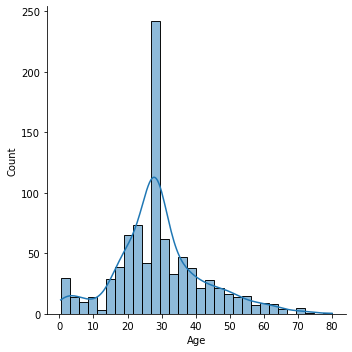

In [15]:
# distribuzione della popolazione sulla base dell'età
s = sns.displot(trainData['Age'],kde= True)

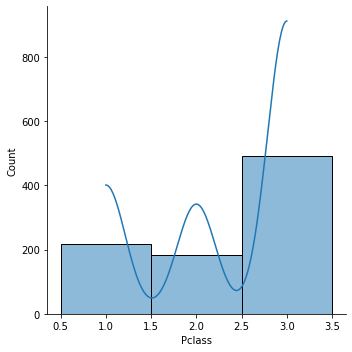

In [16]:
# distribuzione della popolazione sulla base della classe
s = sns.displot(trainData['Pclass'],kde= True)

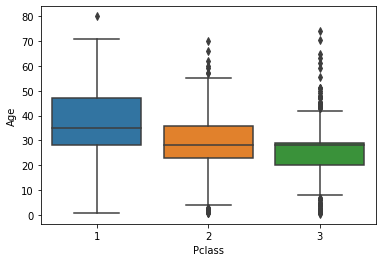

In [17]:
# distribuzione dei passeggeri sulla base di età e classe
s = sns.boxplot(data = trainData, x = 'Pclass', y = 'Age')

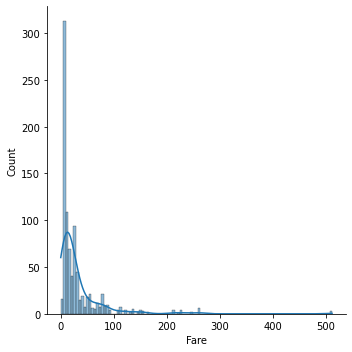

In [18]:
# distribuzione dei passeggeri sulla base del prezzo del biglietto
s = sns.displot(trainData['Fare'],kde= True)

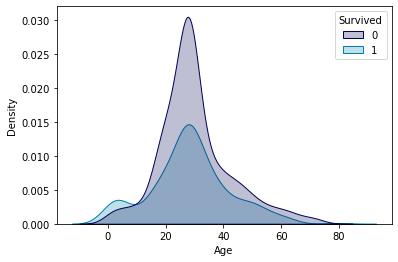

In [19]:
# distribuzione dei sopravvissuti sulla base dell'età
s = sns.kdeplot(data = trainData, x = 'Age', hue= 'Survived', shade= True, palette = 'ocean')

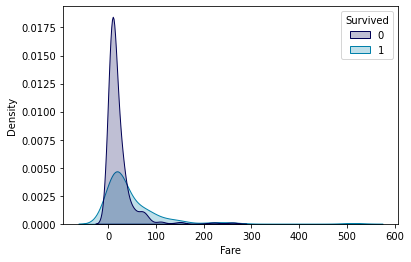

In [20]:
# distribuzione dei sopravvissuti sulla base del prezzo pagato per il biglietto
s = sns.kdeplot(data = trainData, x = 'Fare', hue= 'Survived', shade= True, palette = 'ocean')

Dai grafici precedenti è possibile dedurre diverse informazioni:
- la maggior parte delle persone sulla nave aveva circa 30 anni
- la classe più scelta è ovviamente la terza, in quanto è la più economica e quella destinata anche allo staff
- i passeggeri più anziani sono quelli che hanno speso anche di più per il biglietto
- dal grafico è possibile dedurre che i bambini sono quelli che hanno avuto la possibilità maggiore di salvarsi


# ANALISI PRELIMINARE DEGLI ATTRIBUTI
Prima di costruire il modello di Machine Learning analizziamo gli attributi presenti nel dataset per vedere se esiste una correlazione fra essi, e fra essi e la classe che dobbiamo predirre, ovvero la sopravvivenza.
Per farlo utilizziamo un tipo di analisi statistica chiamata **Chi Square Analysis** che permette di determinare la correlazione fra 2 variabili all'interno del dataset, decidendo quindi se accettare o rifiutare l'**ipotesi nulla**. (Per ipotesi nulla si intende la totale indipendenza fra 2 variabili considerate casuali).

Facciamo questi test al fine di trovare un modo per ridurre la **varianza** e il **bias** del nostro dataset e ottenere risultati migliori tramite l'utilizzo del modello di ML.

In [21]:
# definisco la funzione per l'analisi Chi Quadro
def chi_square_p(x, y):
    df = pd.crosstab(index=trainData[x], columns=trainData[y])
    chisq, p, dof, expected = chi2_contingency(df)
    print(f"The p-value from the chi-square test between the {x} and {y} variables is {p}.")

Considerando una tolleranza di alpha = 0.01, più il p-value restituito fra una coppia di variabili è basso, più esse sono correlate fra loro. 
Analizziamo prima la correlazione fra sesso, cabina, punto di imbarco e biglietto rispetto alla sopravvivenza del passeggero.

In [22]:
chi_square_p('Pclass','Survived')
chi_square_p('Sex','Survived')
chi_square_p('Age','Survived')
chi_square_p('TicketNumber','Survived')
chi_square_p('Embarked','Survived')

The p-value from the chi-square test between the Pclass and Survived variables is 4.549251711298793e-23.
The p-value from the chi-square test between the Sex and Survived variables is 1.1973570627755645e-58.
The p-value from the chi-square test between the Age and Survived variables is 0.028588492552294256.
The p-value from the chi-square test between the TicketNumber and Survived variables is 0.011520301721613752.
The p-value from the chi-square test between the Embarked and Survived variables is 2.3008626481449577e-06.


Possiamo vedere come, dal test appena eseguito, che le variabili maggiormente correlate alla sopravvivenza sono la classe e il sesso.
Al contrario, possiamo vedere che il numero del biglietto e l'età sembrano influenzare in maniera minore la sopravvivenza del passeggero.

In [23]:
chi_square_p('Embarked','TicketNumber')
chi_square_p('Pclass','TicketNumber')

The p-value from the chi-square test between the Embarked and TicketNumber variables is 1.0670929572963141e-13.
The p-value from the chi-square test between the Pclass and TicketNumber variables is 6.224537461754601e-14.


Possiamo vedere che l'attributo ticketNumber sembra essere fortemente dipendente dalla classe e dal punto di imbarco del passeggero, e questo ha ovviamente senso in quanto un biglietto viene emesso tenendo conto della classe della camera scelta e ovviamente anche del luogo di imbarco, tramite un codice univoco.

# FEATURE ENGINEERING
Dai test Chi Quadro svolti in precedenza abbiamo visto come il sesso e la classe sembrano essere gli attributi maggiormente collegati alla sopravvivenza del passeggero; di conseguenza possiamo **cercare di aumentare il loro impatto sull'algoritmo di predizione** attuando del feature engineering e creando un nuovo attributo che combini questi due in una nuova variabile di tipo categoria.
Creiamo quindi una nuova variabile Pclass_Sex.

In [24]:
trainData["Pclass_Sex"] = trainData["Pclass"].astype("string") + trainData["Sex"].astype("string")
trainData["Pclass_Sex"] = trainData["Pclass_Sex"].astype("category")
trainData

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,TicketNumber,Pclass_Sex
0,0,3,male,22.0,1,0,7.2500,S,21171,3male
1,1,1,female,38.0,1,0,71.2833,C,17599,1female
2,1,3,female,26.0,0,0,7.9250,S,3101282,3female
3,1,1,female,35.0,1,0,53.1000,S,113803,1female
4,0,3,male,35.0,0,0,8.0500,S,373450,3male
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,211536,2male
887,1,1,female,19.0,0,0,30.0000,S,112053,1female
888,0,3,female,28.0,1,2,23.4500,S,6607,3female
889,1,1,male,26.0,0,0,30.0000,C,111369,1male


Svolgiamo ora nuovamente un test Chi Quadro per vedere se è aumentata la correlazione rispetto all'attributo Survived.

In [25]:
chi_square_p('Pclass_Sex','Survived')

The p-value from the chi-square test between the Pclass_Sex and Survived variables is 1.2523073473573166e-73.


Vediamo che la correlazione è aumentata notevolmente. Di conseguenza questa feature è buona e verrà inclusa nel dataset al fine di migliorare l'apprendimento dell'algoritmo.

# CREAZIONE E FITTING MODELLO DI MACHINE LEARNING
Essendo un problema di classificazione binario, la sopravvivenza è indicata tramite un valore booleano, ed essendo un problema relativamente facile, decido di optare per un modello basato su **alberi di decisione** in modo da poter sfruttare i vantaggi connessi a tale tipo di modello:
- velocità di computazione
- efficienza elevata con attributi di tipo categoria
- resistenza del modello a rumore e ad eventuali missing values

Inoltre decido di utilizzare un metodo **Ensemble**, in grado di abbassare la varianza combinando fra loro diversi modelli. La scelta deve ricadere quindi fra il modello **Random Forest** o il modello **Gradient Boosting**. Normalmente, fra questi due, l'algoritmo di Gradient Boosting ottiene prestazioni superiori in quanto è in grado di combinare diveris weak learner in modo sequenziale, al fine di ottenere un learner con maggior esperienza.
Per verificarlo, e per decidere quindi quale usare anche in base al nostro dataset, posso svolgere un processo di **K fold cross validation** e vedere quale algoritmo ottiene il punteggio migliore.

Prima di poter applicare il modello devo porre i dati di tipo categoria in un formato apposito, tramite un processo chiamato **One Hot Encoding**.

In [26]:
# One Hot Encoding
cats = ["Pclass","Sex","Embarked","Pclass_Sex"]
train_cats = trainData[cats]
dummies = pd.get_dummies(train_cats)
trainData = trainData.drop(cats, axis=1)
trainData = pd.concat([trainData, dummies], axis=1)
trainData



,Survived,Age,SibSp,Parch,Fare,TicketNumber,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_Sex_1female,Pclass_Sex_1male,Pclass_Sex_2female,Pclass_Sex_2male,Pclass_Sex_3female,Pclass_Sex_3male
0,0,22.0,1,0,7.2500,21171,0,0,1,0,1,0,0,1,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,17599,1,0,0,1,0,1,0,0,1,0,0,0,0,0
2,1,26.0,0,0,7.9250,3101282,0,0,1,1,0,0,0,1,0,0,0,0,1,0
3,1,35.0,1,0,53.1000,113803,1,0,0,1,0,0,0,1,1,0,0,0,0,0
4,0,35.0,0,0,8.0500,373450,0,0,1,0,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,211536,0,1,0,0,1,0,0,1,0,0,0,1,0,0
887,1,19.0,0,0,30.0000,112053,1,0,0,1,0,0,0,1,1,0,0,0,0,0
888,0,28.0,1,2,23.4500,6607,0,0,1,1,0,0,0,1,0,0,0,0,1,0
889,1,26.0,0,0,30.0000,111369,1,0,0,0,1,1,0,0,0,1,0,0,0,0


In [27]:
# preparo i dati
y_train = trainData['Survived']
x_train = trainData.drop('Survived',axis=1)

# istanzio il modello
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
cb = CatBoostClassifier()


# K-fold cross validation
np.random.seed(64)
rf_score = np.mean(cross_validate(rf, x_train, y_train, cv=10)['test_score'])
np.random.seed(64)
gb_score = np.mean(cross_validate(gb, x_train, y_train, cv=10)['test_score'])

print(f"Random Forest Score:{rf_score}")
print(f"Gradient Boost Score:{gb_score}")

Random Forest Score:0.8316853932584269
Gradient Boost Score:0.842896379525593


La scelta ricade quindi, come pronosticato, sul Gradient Boosting. In particolare, decido di utilizzare il CatBoost.

In [28]:
# fitto il modello sui miei dati di training
cb.fit(x_train,y_train)

Learning rate set to 0.009807
0:	learn: 0.6866295	total: 56.3ms	remaining: 56.3s
1:	learn: 0.6798268	total: 58ms	remaining: 28.9s
2:	learn: 0.6745496	total: 58.7ms	remaining: 19.5s
3:	learn: 0.6701551	total: 59.7ms	remaining: 14.9s
4:	learn: 0.6645863	total: 61.2ms	remaining: 12.2s
5:	learn: 0.6585252	total: 62.5ms	remaining: 10.4s
6:	learn: 0.6528365	total: 64ms	remaining: 9.08s
7:	learn: 0.6477182	total: 65.3ms	remaining: 8.1s
8:	learn: 0.6418527	total: 66.6ms	remaining: 7.33s
9:	learn: 0.6372151	total: 68ms	remaining: 6.73s
10:	learn: 0.6319435	total: 69.1ms	remaining: 6.21s
11:	learn: 0.6267573	total: 70.3ms	remaining: 5.79s
12:	learn: 0.6214360	total: 71.5ms	remaining: 5.43s
13:	learn: 0.6161168	total: 72.7ms	remaining: 5.12s
14:	learn: 0.6117087	total: 73.9ms	remaining: 4.85s
15:	learn: 0.6072863	total: 75.1ms	remaining: 4.62s
16:	learn: 0.6029080	total: 75.9ms	remaining: 4.39s
17:	learn: 0.5981407	total: 77.2ms	remaining: 4.21s
18:	learn: 0.5941960	total: 78.5ms	remaining: 4.05s

Possiamo ora sfruttare un metodo integrato nell'algoritmo per vedere a queli features del nostro dataset è stata assegnata la maggior importanza nell'ambito dell'apprendimento.

In [29]:
featureImportance = cb.get_feature_importance()
n = len(featureImportance)
lista = list(trainData)
print("Importanza delle features nell'addestramento del modello di previsione.")
for i in range(1,n):
        print(lista[i] + ": \t" + str(featureImportance[i]))

Importanza delle features nell'addestramento del modello di previsione.
Age: 	5.178575995211336
SibSp: 	3.608703629147835
Parch: 	13.687484872205168
Fare: 	15.396103998439981
TicketNumber: 	1.6798905136385078
Pclass_1: 	1.2744236985275414
Pclass_2: 	3.931718906330901
Pclass_3: 	13.268579954439934
Sex_female: 	12.81428094684063
Sex_male: 	0.7050762429056114
Embarked_C: 	0.7473732655811043
Embarked_Q: 	2.049385136571289
Embarked_S: 	2.1197737352532258
Pclass_Sex_1female: 	1.3475762949578112
Pclass_Sex_1male: 	1.380688485413533
Pclass_Sex_2female: 	1.6393303248122633
Pclass_Sex_2male: 	3.2439591332946422
Pclass_Sex_3female: 	0.920808490219339


Visualizziamo ora l'albero di decisione finale, ovvero quello ottenuto all'ultima iterazione combinando diversi weak learner al fine di creare un learner completo in grado di predirre la classe di sopravvivenza.

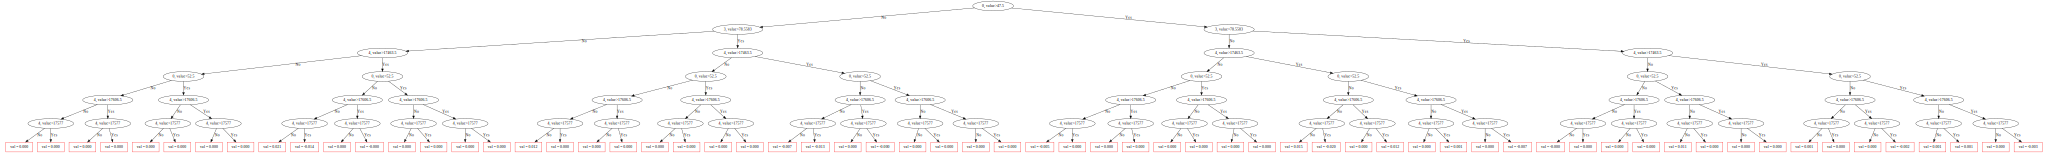

In [30]:
cb.plot_tree(999)

In [31]:
testData

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


Ora bisogna ripetere il preprocessing fatto sui dati di training anche sui dati di testing, in modo da metterli nelle stesse condizioni dei dati sui quali è stato addestrato il modello.

In [32]:
# elimino le features inutili
testData = testData.drop(['Name','Cabin'],axis=1)

# fillo i missing data su Embarked e Age
testData = testData.fillna(value = {"Embarked": "S"})
testData = testData.fillna(testData['Age'].median())

# ora elimino le parti alfabetiche
testData["TicketNumber"] = pd.to_numeric(testData["Ticket"].replace(".* {1}([0-9]*)$", "\\1", regex=True).replace("LINE","0")).astype("int64")
# con questa istruzione ho sostituito tutti i numeri o i caratteri speciali con uno spazio vuoto
testData = testData.drop("Ticket", axis=1) # rimuovo la vecchia colonna ticket

# cambio tipo ai dati oggetto
testData['Pclass']=testData['Pclass'].astype('category')
testData['Sex']=testData['Sex'].astype('category')
testData['Embarked']=testData['Embarked'].astype('category')

# creo attributo composto Pclass_Sex
testData["Pclass_Sex"] = testData["Pclass"].astype("string") + testData["Sex"].astype("string")
testData["Pclass_Sex"] = testData["Pclass_Sex"].astype("category")

# One Hot Encoding
cats = ["Pclass","Sex","Embarked","Pclass_Sex"]
test_cats = testData[cats]
dummies = pd.get_dummies(test_cats)
testData = testData.drop(cats, axis=1)
testData = pd.concat([testData, dummies], axis=1)
testData

,PassengerId,Age,SibSp,Parch,Fare,TicketNumber,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_Sex_1female,Pclass_Sex_1male,Pclass_Sex_2female,Pclass_Sex_2male,Pclass_Sex_3female,Pclass_Sex_3male
0,892,34.5,0,0,7.8292,330911,0,0,1,0,1,0,1,0,0,0,0,0,0,1
1,893,47.0,1,0,7.0000,363272,0,0,1,1,0,0,0,1,0,0,0,0,1,0
2,894,62.0,0,0,9.6875,240276,0,1,0,0,1,0,1,0,0,0,0,1,0,0
3,895,27.0,0,0,8.6625,315154,0,0,1,0,1,0,0,1,0,0,0,0,0,1
4,896,22.0,1,1,12.2875,3101298,0,0,1,1,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,27.0,0,0,8.0500,3236,0,0,1,0,1,0,0,1,0,0,0,0,0,1
414,1306,39.0,0,0,108.9000,17758,1,0,0,1,0,1,0,0,1,0,0,0,0,0
415,1307,38.5,0,0,7.2500,3101262,0,0,1,0,1,0,0,1,0,0,0,0,0,1
416,1308,27.0,0,0,8.0500,359309,0,0,1,0,1,0,0,1,0,0,0,0,0,1


Ora predico i valori di test a partire dal modello allenato sui dati di training

In [33]:
pName = testData['PassengerId']
testData = testData.drop('PassengerId',axis=1)

results = pd.DataFrame({"PassengerId": pName, "Survived": cb.predict(testData)})
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Ora posso fare io submit della mia previsione.

In [34]:
# salvo come csv
results.to_csv("/kaggle/working/submission.csv", index=False)

